In [1]:
##
## AlexNet analog (Krizhevsky 2012)
##
## 2017-05-20
## maximum on LB => 0.84500
##
## TIF - (,,6) (,,3)
##
## 2017-07-06
##  TIF (64,64,6) - полная схема без выемки 09(cloudy) - то есть 17 признаков
##  
## 2017-07-09
##  TIF (64,64,6) - полная схема по признакам 4,5,6,7
##
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm

from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, getProbX01, getTh, estimateResult

In [6]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [7]:
keras.__version__

'2.0.4'

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
#del(trOX); del(trOY);

In [15]:
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy',trX)
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy',trY)

In [28]:
if False :
    ###trXX = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-XX.npy')
    ###trYY = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy')
    trXX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX.npy')
    trYY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY.npy')

    trX, trY = trXX[trYY[:,9]==0], trYY[trYY[:,9]==0] # not cloudy == 9 feature
    trY=trY[:,range(0,9)+range(10,17)] # --cloudy <> 9
    del trXX,trYY
    #print(trXX.shape,trYY.shape)
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX-short.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY-short.npy')
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy')
    print(trX.shape,trY.shape)
    
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-XX-tif.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-YY-tif.npy')
    
if False : # VGG16-19
    trX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY.npy')
    
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy')
    
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY.npy')
    print(trX.shape,trY.shape)
    
    
if False :
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-YY-tif.npy')
    trX0 = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-tif.npy')
    trX1 = np.load('../Data-Keras/Datas/train-model-2D-128x128x8-XX-tif.npy')
    #trX1 = trX1[:,:,:,3:]
    trX  = np.zeros((trX0.shape[0],trX0.shape[1],trX0.shape[2],trX0.shape[3]+trX1.shape[3]),dtype=np.uint8)
    print (trX0.shape,trX1.shape,trX.shape)
    trX[:,:,:,0:3] = trX0; del trX0
    trX[:,:,:,3:]  = trX1; del trX1
    
if True :
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-YY-tif.npy')
    #trX0 = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-tif.npy')
    trX1 = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-XX-tif.npy')
    #trX1 = trX1[:,:,:,3:]
    #trX  = np.zeros((trX0.shape[0],trX0.shape[1],trX0.shape[2],trX0.shape[3]+trX1.shape[3]),dtype=np.uint8)
    trX  = trX1[:,:,:,3:8]
    #print (trX0.shape,trX1.shape,trX.shape)
    #trX[:,:,:,0:3] = trX0; del trX0
    #trX[:,:,:,3:]  = trX1; del trX1
    del trX1
    
    
if False :
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-YY-tif.npy')
    trX0 = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX-tif.npy')
    trX1 = np.load('../Data-Keras/Datas/train-model-2D-64x64x8-XX-tif.npy')
    #trX1 = trX1[:,:,:,3:]
    trX  = np.zeros((trX0.shape[0],trX0.shape[1],trX0.shape[2],trX0.shape[3]+trX1.shape[3]),dtype=np.uint8)
    print (trX0.shape,trX1.shape,trX.shape)
    trX[:,:,:,0:3] = trX0
    trX[:,:,:,3:]  = trX1
    del trX0,trX1
    
print(trX.shape,trY.shape)

(40479, 64, 64, 4) (40479, 17)


In [29]:
#del trX0,trX1,trX

In [83]:
trX.shape
ndvi_min, ndvi_max = np.zeros(trX.shape[0],dtype=np.float16), np.zeros(trX.shape[0],dtype=np.float16)
ccci               = np.zeros((trX.shape[0],trX.shape[1],trX.shape[2]),dtype=np.uint8)
for ii in range(trX.shape[0]) :
    ndvi_min[ii], ndvi_max[ii] = trX[ii,:,:,0].min(), trX[ii,:,:,0].max()
    ccci[ii] = (trX[ii,:,:,0]-ndvi_min[ii])/(ndvi_max[ii]-ndvi_min[ii])*256.0
ccci.shape
trX[:,:,:,3]=ccci

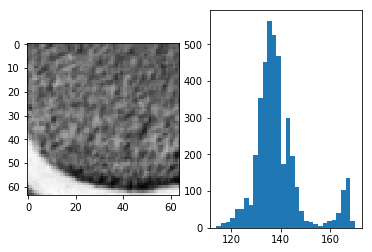

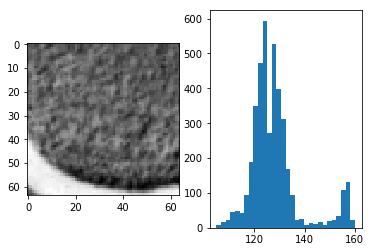

In [110]:
ii = 50
#plt.imshow(np.array(ccci[ii]*256.0,dtype=np.uint8),'gray'); plt.show()
#plt.subplot(121);plt.imshow(ccci[ii],'gray'); plt.subplot(122);plt.hist(ccci[ii].ravel(),bins=50); 
#plt.show()
plt.subplot(121);plt.imshow(trX[ii,:,:,0],'gray'); plt.subplot(122);plt.hist(trX[ii,:,:,0].ravel(),bins=30); 
plt.show()
plt.subplot(121);plt.imshow(trX[ii,:,:,1],'gray'); plt.subplot(122);plt.hist(trX[ii,:,:,1].ravel(),bins=30); 
plt.show()

In [111]:
print(trX.shape,trY.shape)
###del trX, trY

(40479, 64, 64, 4) (40479, 4)


In [31]:
# Берем из признаков только 4,5,6,7 - проблемные
trY_old = trY
trY=trY[:,4:8]
print(trX.shape,trY.shape)

(40479, 64, 64, 4) (40479, 4)


In [112]:
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [113]:
from keras.models import Model, Input
from keras.layers import Conv2D

def VGG16XX ( include_top=True, 
              weights='imagenet',
              input_tensor=None, input_shape=None,
              pooling=None,
              classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    
    '''
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)
    '''
    
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor    
    # Block 1
    ##x = BatchNormalization()(img_input) ##-------------------------------
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    x = Dropout(0.25)(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        '''
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        '''
        
        x = Dense(1024, activation='relu', name='fc1')(x) ##
        x = Dropout(0.25)(x)
        x = Dense(1024, activation='relu', name='fc2')(x) ## 
        x = Dropout(0.25)(x)
        
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16XX')
    
    """
    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    """
    return model

In [114]:
#model11 = VGG16XX(input_shape=(128,128,12),classes=4)
#model11.summary()
#del model11

In [115]:
input_shape, output_classes, metric = (trX.shape[1],trX.shape[2],trX.shape[3]), trY.shape[1], 'acc'
print(input_shape,output_classes)

(64, 64, 4) 4


In [116]:
K.clear_session()
model10 = VGG16XX(input_shape=input_shape,classes=output_classes)
model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 4)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        2368      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [117]:
sgd = keras.optimizers.SGD(nesterov=True)
model10.compile(loss='binary_crossentropy', # 'mean_absolute_error'
              optimizer=sgd, #"nadam", #sgd, #"adam", #'rmsprop',
              metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

In [118]:
if False : model10.load_weights('../Data-Keras/Models/model-Alex-weights-128x128x3.h5', by_name=False)

In [119]:
sweight  = np.zeros(trY.shape[0],dtype=np.float32);
sweight[:]  = 1.0
sweight[trY[:,0]==1] = 0.35
sweight[trY[:,1]==1] = 0.25
sweight[trY[:,2]==1] = 0.15
sweight[trY[:,3]==1] = 0.05

In [120]:
epochs     = 10
verbose    = 2
batch_size = 256
stopping   = 5

prefixTemp = 'tif-64x64xX'     

early_stopping = EarlyStopping(monitor='val_loss', patience=stopping,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

filepath="../Temp/Temp/"+prefixTemp+"-weights.{epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}-.hdf5"
##checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')

tr1    = np.sum([K.count_params(p) for p in set(model10.trainable_weights)])
tr2    = np.sum([K.count_params(p) for p in set(model10.non_trainable_weights)])

step = 5000
low  = 0
high = low+step

xxyy = 0
#trXX = trX #[trY[:,xxyy]==1]
#trYY = trY #[trY[:,xxyy]==1]

print(datetime.datetime.now(),tr1+tr2)
#hist1  = model10.fit(trX[low:high],trY[low:high],
#hist1  = model10.fit(trX[low:high],trY[low:high],
hist1  = model10.fit(trX,trY,
                    #sample_weight=sweight[low:high],
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.20, 
                    #initial_epoch=31,
                    callbacks=[early_stopping,checkpoint, reduce_lr],
                    verbose=verbose)

##trP = model1.predict(trX, batch_size=128)
##fbeta2score=fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
##fbeta2pred =K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64)))
print(datetime.datetime.now()) #,pp,'fbeta2s=',fbeta2score,fbeta2pred)


2017-07-11 01:58:31.329459 17867140.0
Train on 32383 samples, validate on 8096 samples
Epoch 1/10
Epoch 00000: acc improved from -inf to 0.85504, saving model to ../Temp/Temp/tif-64x64xX-weights.00-acc=0.8550-val_acc=0.8598-.hdf5
159s - loss: 0.4354 - acc: 0.8550 - val_loss: 0.4266 - val_acc: 0.8598
Epoch 2/10
Epoch 00001: acc improved from 0.85504 to 0.85837, saving model to ../Temp/Temp/tif-64x64xX-weights.01-acc=0.8584-val_acc=0.8628-.hdf5
148s - loss: 0.4267 - acc: 0.8584 - val_loss: 0.4200 - val_acc: 0.8628
Epoch 3/10
Epoch 00002: acc improved from 0.85837 to 0.86134, saving model to ../Temp/Temp/tif-64x64xX-weights.02-acc=0.8613-val_acc=0.8639-.hdf5
149s - loss: 0.4225 - acc: 0.8613 - val_loss: 0.4217 - val_acc: 0.8639
Epoch 4/10
Epoch 00003: acc improved from 0.86134 to 0.86290, saving model to ../Temp/Temp/tif-64x64xX-weights.03-acc=0.8629-val_acc=0.8681-.hdf5
148s - loss: 0.4202 - acc: 0.8629 - val_loss: 0.4158 - val_acc: 0.8681
Epoch 5/10
Epoch 00004: acc improved from 0.8629

In [121]:
trX.shape, trY.shape

((40479, 64, 64, 4), (40479, 4))

In [122]:
%time trP = model10.predict(trX, batch_size=batch_size)
trP01       = getProb01(trP)
#th, _       = getTh(trY,trP)
#trP01x      = getProbX01(trP,th)

CPU times: user 7.42 s, sys: 2.5 s, total: 9.92 s
Wall time: 55.9 s


In [123]:
print(model10.evaluate(trX,trY,verbose=2))
print(trY.shape)
print(trP.shape)
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.5, beta=2, average='samples'))
##-------------
print('fbeta_score=',fbeta_score(trY,trP01, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01.astype(np.float64))))
##-------------
#print('fbeta_score=',fbeta_score(trY,trP01x, beta=2, average='samples'))
#print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01x.astype(np.float64))))

[0.41454916562898941, 0.86520788556146078]
(40479, 4)
(40479, 4)
fbeta_score= 0.0730534652961
fbeta_pred = 0.39200095867


In [292]:
if True :
    save_model(model10,'../Data-Keras/Models/model-VGG16-64x64x11-d2048xd2048.h5')
    model10.save_weights('../Data-Keras/Models/model-VGG16-weights-64x64x11--d2048xd2048.h5')

In [293]:
model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 11)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 11)        44        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        6400      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
__________

In [138]:
trP[0], trY[0]

(array([ 0.13789362,  0.01323014,  0.06813941,  0.05523191], dtype=float32),
 array([0, 0, 0, 0]))

In [139]:
# Результативность

In [44]:
temp = estimateResult(trY,trP01,printOK=True) # 40000 tif128[:,:,:,4:] (10) VGG d1024+d1024

0 acc=0.886731391586 roc=0.728090576702 not=4585 yes=3541 no=32353 true=35894 all-1-0=(0.4778-0.9784)
1 acc=0.909582746609 roc=0.5 not=3660 yes=0 no=36819 true=36819 all-1-0=(0.0000-1.0000)
2 acc=0.80150201339 roc=0.502555860233 not=8035 yes=43 no=32401 true=32444 all-1-0=(0.0053-0.9998)
3 acc=0.889399441686 roc=0.5 not=4477 yes=0 no=36002 true=36002 all-1-0=(0.0000-1.0000)


In [337]:
temp = estimateResult(trY,trP01,printOK=True) # 40000 jpg128+tif128 (10) VGG d1024+d1024

0 acc=0.875169841152 roc=0.694160279011 not=5053 yes=3028 no=32398 true=35426 all-1-0=(0.4086-0.9797)
1 acc=0.909582746609 roc=0.5 not=3660 yes=0 no=36819 true=36819 all-1-0=(0.0000-1.0000)
2 acc=0.820450109934 roc=0.564260837866 not=7268 yes=1115 no=32096 true=33211 all-1-0=(0.1381-0.9904)
3 acc=0.889399441686 roc=0.5 not=4477 yes=0 no=36002 true=36002 all-1-0=(0.0000-1.0000)


In [124]:
temp = estimateResult(trY,trP01,printOK=True) # 40000 jpg128+tif128 (10) VGG d2048+d2048

0 acc=0.868153857556 roc=0.667513962348 not=5337 yes=2601 no=32541 true=35142 all-1-0=(0.3510-0.9841)
1 acc=0.909582746609 roc=0.5 not=3660 yes=0 no=36819 true=36819 all-1-0=(0.0000-1.0000)
2 acc=0.79369549643 roc=0.535549349636 not=8351 yes=857 no=31271 true=32128 all-1-0=(0.1062-0.9649)
3 acc=0.889399441686 roc=0.5 not=4477 yes=0 no=36002 true=36002 all-1-0=(0.0000-1.0000)


In [288]:
temp = estimateResult(trY,trP01,printOK=True) # 40000 jpg64 VGG

0 acc=0.902640875516 roc=0.778292256694 not=3941 yes=4314 no=32224 true=36538 all-1-0=(0.5821-0.9745)
1 acc=0.910225054967 roc=0.503551912568 not=3634 yes=26 no=36819 true=36845 all-1-0=(0.0071-1.0000)
2 acc=0.865782257467 roc=0.740418355642 not=5433 yes=4293 no=30753 true=35046 all-1-0=(0.5319-0.9489)
3 acc=0.889399441686 roc=0.5 not=4477 yes=0 no=36002 true=36002 all-1-0=(0.0000-1.0000)


In [228]:
temp = estimateResult(trY,trP01,printOK=True) # 40000 jpg64 VGG

0 acc=0.89644012945 roc=0.757222563118 not=4192 yes=3984 no=32303 true=36287 all-1-0=(0.5376-0.9769)
1 acc=0.914918846809 roc=0.530369421258 not=3444 yes=223 no=36812 true=37035 all-1-0=(0.0609-0.9998)
2 acc=0.850515081894 roc=0.698039209517 not=6051 yes=3587 no=30841 true=34428 all-1-0=(0.4444-0.9516)
3 acc=0.893352108501 roc=0.529017603407 not=4317 yes=274 no=35888 true=36162 all-1-0=(0.0612-0.9968)


In [141]:
temp = estimateResult(trY,trP01,printOK=True) # 40000 jpg64 VGG

0 acc=0.832209293708 roc=0.567673970869 not=6792 yes=1114 no=32573 true=33687 all-1-0=(0.1503-0.9850)
1 acc=0.90968156328 roc=0.501407672624 not=3656 yes=11 no=36812 true=36823 all-1-0=(0.0030-0.9998)
2 acc=0.820351293263 roc=0.590623565462 not=7272 yes=1683 no=31524 true=33207 all-1-0=(0.2085-0.9727)
3 acc=0.889399441686 roc=0.5 not=4477 yes=0 no=36002 true=36002 all-1-0=(0.0000-1.0000)


In [256]:
temp = estimateResult(trY,trP01,printOK=True) # 40000 jpg64 VGG

0 acc=0.883223399788 roc=0.716154611759 not=4727 yes=3354 no=32398 true=35752 all-1-0=(0.4526-0.9797)
1 acc=0.909582746609 roc=0.5 not=3660 yes=0 no=36819 true=36819 all-1-0=(0.0000-1.0000)
2 acc=0.823834580894 roc=0.578842383434 not=7131 yes=1383 no=31965 true=33348 all-1-0=(0.1714-0.9863)
3 acc=0.889399441686 roc=0.5 not=4477 yes=0 no=36002 true=36002 all-1-0=(0.0000-1.0000)


In [165]:
temp = estimateResult(trY,trP01,printOK=True) # 10000 +jpg64+tif64

0 acc=0.866350453321 roc=0.681224354661 not=5410 yes=2884 no=32185 true=35069 all-1-0=(0.3892-0.9733)
1 acc=0.909706267447 roc=0.501052156339 not=3655 yes=8 no=36816 true=36824 all-1-0=(0.0022-0.9999)
2 acc=0.845574248376 roc=0.696349208737 not=6251 yes=3617 no=30611 true=34228 all-1-0=(0.4481-0.9446)
3 acc=0.889399441686 roc=0.5 not=4477 yes=0 no=36002 true=36002 all-1-0=(0.0000-1.0000)


In [152]:
temp = estimateResult(trY,trP01,printOK=True) # 10000 + weight

0 acc=0.825316830949 roc=0.534350503276 not=7071 yes=558 no=32850 true=33408 all-1-0=(0.0753-0.9934)
1 acc=0.909582746609 roc=0.5 not=3660 yes=0 no=36819 true=36819 all-1-0=(0.0000-1.0000)
2 acc=0.800612663356 roc=0.5 not=8071 yes=0 no=32408 true=32408 all-1-0=(0.0000-1.0000)
3 acc=0.889399441686 roc=0.5 not=4477 yes=0 no=36002 true=36002 all-1-0=(0.0000-1.0000)


In [142]:
temp = estimateResult(trY,trP01,printOK=True) # 10000 + weight

0 acc=0.776180241607 roc=0.731723479904 not=9060 yes=4903 no=26516 true=31419 all-1-0=(0.6616-0.8019)
1 acc=0.909582746609 roc=0.5 not=3660 yes=0 no=36819 true=36819 all-1-0=(0.0000-1.0000)
2 acc=0.832159885373 roc=0.624794903727 not=6794 yes=2259 no=31426 true=33685 all-1-0=(0.2799-0.9697)
3 acc=0.889399441686 roc=0.5 not=4477 yes=0 no=36002 true=36002 all-1-0=(0.0000-1.0000)


In [112]:
temp = estimateResult(trY,trP01,printOK=True) # 40497

0 acc=0.890511129228 roc=0.763120816684 not=4432 yes=4166 no=31881 true=36047 all-1-0=(0.5621-0.9641)
1 acc=0.915289409323 roc=0.543368456414 not=3429 yes=327 no=36723 true=37050 all-1-0=(0.0893-0.9974)
2 acc=0.858321598854 roc=0.705845428811 not=5735 yes=3650 no=31094 true=34744 all-1-0=(0.4522-0.9595)
3 acc=0.890264087552 roc=0.511830166361 not=4442 yes=116 no=35921 true=36037 all-1-0=(0.0259-0.9978)


In [104]:
temp = estimateResult(trY,trP01,printOK=True) # 10000

0 acc=0.882506978927 roc=0.720322650364 not=4756 yes=3442 no=32281 true=35723 all-1-0=(0.4644-0.9762)
1 acc=0.91049680081 roc=0.564602169942 not=3623 yes=521 no=36335 true=36856 all-1-0=(0.1423-0.9869)
2 acc=0.845104869191 roc=0.747044076636 not=6270 yes=4713 no=29496 true=34209 all-1-0=(0.5839-0.9101)
3 acc=0.889399441686 roc=0.5 not=4477 yes=0 no=36002 true=36002 all-1-0=(0.0000-1.0000)


In [83]:
temp = estimateResult(trY,trP01,printOK=True)

0 acc=0.958348773438 roc=0.799160605167 not=1686 yes=1660 no=37133 true=38793 all-1-0=(0.6155-0.9828)
1 acc=0.963240198622 roc=0.80939353027 not=1488 yes=37125 no=1866 true=38991 all-1-0=(0.9897-0.6291)
2 acc=0.873909928605 roc=0.845756934198 not=5104 yes=9530 no=25845 true=35375 all-1-0=(0.7739-0.9177)
3 acc=0.928432026483 roc=0.903017204686 not=2897 yes=27459 no=10123 true=37582 all-1-0=(0.9658-0.8402)
4 acc=0.892314533462 roc=0.745117976905 not=4359 yes=3801 no=32319 true=36120 all-1-0=(0.5129-0.9773)
5 acc=0.917858642753 roc=0.600514301463 not=3325 yes=780 no=36374 true=37154 all-1-0=(0.2131-0.9879)
6 acc=0.864250599076 roc=0.768351903302 not=5495 yes=4914 no=30070 true=34984 all-1-0=(0.6088-0.9279)
7 acc=0.893722671015 roc=0.574700047997 not=4302 yes=739 no=35438 true=36177 all-1-0=(0.1651-0.9843)
8 acc=0.994836828973 roc=0.5 not=209 yes=0 no=40270 true=40270 all-1-0=(0.0000-1.0000)
9 acc=0.978532078362 roc=0.86827718369 not=869 yes=1557 no=38053 true=39610 all-1-0=(0.7453-0.9912)

In [43]:
temp = estimateResult(trY,trP01,printOK=True)

0 acc=0.914004792609 roc=0.791948027198 not=3481 yes=4442 no=32556 true=36998 all-1-0=(0.5994-0.9845)
1 acc=0.933125818326 roc=0.673498547836 not=2707 yes=1305 no=36467 true=37772 all-1-0=(0.3566-0.9904)
2 acc=0.879690703822 roc=0.767480634104 not=4870 yes=4688 no=30921 true=35609 all-1-0=(0.5808-0.9541)
3 acc=0.901306850466 roc=0.603901122213 not=3995 yes=994 no=35490 true=36484 all-1-0=(0.2220-0.9858)


In [45]:
np.array(temp,dtype=np.int32)

array([[    0, 40479,     0,     0,  7411, 33068,  4442, 32556,  3481],
       [    1, 40479,     0,     0,  3660, 36819,  1305, 36467,  2707],
       [    2, 40479,     0,     0,  8071, 32408,  4688, 30921,  4870],
       [    3, 40479,     0,     0,  4477, 36002,   994, 35490,  3995]], dtype=int32)

In [136]:
print(trY.shape)
fres = []
trP01 = getProb01(trP)
for i in range(trY.shape[1]) :
        cm = confusion_matrix(trY[:,i],trP01[:,i])
        print('{} acc={} roc={} not={} yes={} no={} true={} all-1-0=({:.4f}-{:.4f})'.format(i,
                  skm.accuracy_score(trY[:,i],trP01[:,i]),
                  skm.roc_auc_score(trY[:,i],trP01[:,i]),
                  cm[0,1]+cm[1,0],
                  cm[0,0],cm[1,1],
                  cm[0,0]+cm[1,1],
                  float(cm[0,0])/len(trY[trY[:,i]==1,i]),
                  float(cm[1,1])/len(trY[trY[:,i]==0,i]),
                 ));
        fres.append ((i,trY.shape[0],
                skm.accuracy_score(trY[:,i],trP01[:,i]),
                #skm.accuracy_score(trY[:,i],trP01[:,i]),
                skm.roc_auc_score(trY[:,i],trP01[:,i]),
                  cm[0,1]+cm[1,0]))
fresList.append(fres)

(40479, 5)
0 acc=0.953556164925 roc=0.776106519169 not=1880 yes=1541 no=37058 true=38599 all-1-0=(0.5714-0.9808)
1 acc=0.958422885941 roc=0.857560689368 not=1683 yes=36603 no=2193 true=38796 all-1-0=(0.9757-0.7394)
2 acc=0.85733343215 roc=0.788034858816 not=5775 yes=7525 no=27179 true=34704 all-1-0=(0.6110-0.9650)
3 acc=0.813483534672 roc=0.836660016401 not=7550 yes=22159 no=10770 true=32929 all-1-0=(0.7794-0.8939)
4 acc=0.87848019961 roc=0.677864984878 not=4919 yes=2678 no=32882 true=35560 all-1-0=(0.3614-0.9944)


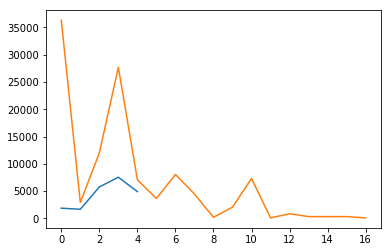

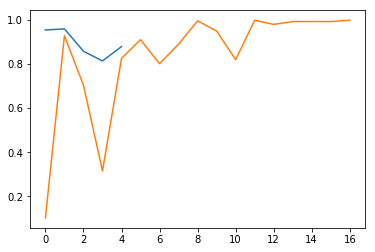

In [137]:
plt.plot([x[4] for x in fresList[-1]]); 
plt.plot([x[4] for x in fresList[-2]]); 
plt.show()
plt.plot([x[2] for x in fresList[-1]]); 
plt.plot([x[2] for x in fresList[-2]]); 
plt.show()

In [31]:
rr, rrx = [], []; trP = model.predict(trX, batch_size=128)
for i in range(trP.shape[1]) :
    xx = [];
    trYY = trY[:,i].astype(np.float64)
    trPY = trP[:,i]
    for ii in range(100) :
        trPP = (trPY>0.01*ii).astype(np.float64)
        #x = fbeta_score(trY[:,0], np.array(trP[:,0] > 0.1*ii), beta=2, average='samples')
        x = K.get_value(fbeta_pred(trYY,trPP))
        xx.append(x)
    rrr = np.array(xx).argmax();
    rr.append(rrr)
    rrx.append(xx[rrr])
    print(datetime.datetime.now(),i,'-->',rrr,xx[rrr],xx[(rrr-1):(rrr+2)])
    #print(xx);
    #plt.plot(np.array(xx)); plt.show()
trM = np.array(rr)/100.0;

2017-05-20 05:22:01.009723 0 --> 70 0.758419290079 [0.75741733368803943, 0.75841929007857778, 0.75785138394714635]
2017-05-20 05:22:23.972821 1 --> 78 0.982638483662 [0.98262473453994426, 0.98263848366246676, 0.98259679666709321]
2017-05-20 05:22:52.632376 2 --> 58 0.847226297632 [0.8469111862002846, 0.84722629763157453, 0.84682213028656683]
2017-05-20 05:23:27.033547 3 --> 78 0.97604678248 [0.97585536488705449, 0.97604678247993626, 0.97586138532621902]
2017-05-20 05:24:07.288213 4 --> 39 0.78729476795 [0.78664609854346335, 0.78729476795032916, 0.78707371492899492]
2017-05-20 05:24:52.980975 5 --> 42 0.789568102568 [0.78871126051941221, 0.78956810256787635, 0.78669767415698355]
2017-05-20 05:25:44.022237 6 --> 47 0.830831644043 [0.8305167161398419, 0.83083164404299403, 0.83015444819651052]
2017-05-20 05:26:40.712293 7 --> 45 0.738016164169 [0.73686966073098015, 0.73801616416924898, 0.73773213859960107]
2017-05-20 05:27:43.679293 8 --> 26 0.676190170231 [0.6690774577597115, 0.6761901702

In [26]:
model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [27]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [34]:
#nameAsk = os.listdir(teDirI); print(len(nameAsk))
nameAsk = os.listdir(teDirJPG); print(len(nameAsk))
trOX, trOY, i, ii, size = [], [], 0, 0, len(nameAsk)
print(datetime.datetime.now(),len(nameAsk),size)
for nn in nameAsk[0:size] :
    #nf = os.path.join(teDirTIF,nn);
    nf = os.path.join(teDirJPG,nn);
    nx = formImExt(nf,resize=(64,64))
    if (nx is not None) :
        trOX.append(nx)
        trOY.append(nn)
    i += 1
    if (i%10000==0) and (i>1) :
        if (ii==0) :
            trOX = np.array(trOX); trOX = trOX / 255.0
            trP = model.predict(trOX, batch_size=512); 
        else :
            trOX = np.array(trOX);  trOX = trOX / 255.0
            trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
        trOX,ii = [],ii+1;
    if (i%5000==0) : print(datetime.datetime.now(),"\t",ii,'\t',i,"\t",nn,'\t',(trP.shape if ii>0 else ""))

if (len(trOX)>0) :
    if (ii==0) :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = model.predict(trOX, batch_size=512); 
    else :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
    trOX,ii = [],ii+1;
    
print(datetime.datetime.now())

#assert (size!=len(trOY)), "Wrong files {} != {}".format(size,len(trOY))

61191
2017-05-20 05:46:19.287685 61191 61191
2017-05-20 05:46:38.218814 	 0 	 5000 	 test_14523.jpg 	 
2017-05-20 05:46:51.023731 	 1 	 10000 	 test_19029.jpg 	 (10000, 17)
2017-05-20 05:46:58.884016 	 1 	 15000 	 test_23524.jpg 	 (10000, 17)
2017-05-20 05:47:09.507695 	 2 	 20000 	 test_28015.jpg 	 (20000, 17)
2017-05-20 05:47:16.475888 	 2 	 25000 	 test_32520.jpg 	 (20000, 17)
2017-05-20 05:47:26.837760 	 3 	 30000 	 test_37026.jpg 	 (30000, 17)
2017-05-20 05:47:33.858034 	 3 	 35000 	 test_4908.jpg 	 (30000, 17)
2017-05-20 05:47:44.019579 	 4 	 40000 	 test_9402.jpg 	 (40000, 17)
2017-05-20 05:47:51.298769 	 4 	 45000 	 file_13913.jpg 	 (40000, 17)
2017-05-20 05:48:01.555641 	 5 	 50000 	 file_18419.jpg 	 (50000, 17)
2017-05-20 05:48:24.538867 	 5 	 55000 	 file_4564.jpg 	 (50000, 17)
2017-05-20 05:48:40.785101 	 6 	 60000 	 file_892.jpg 	 (60000, 17)
2017-05-20 05:48:43.863555


In [36]:
#trOX = np.array(trOX);
trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(len(nameAsk),trP.shape,trOY.shape)

61191 (61191, 17) (61191,)


In [ ]:
# Saving & Loading

In [26]:
np.save('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy',trOX)
np.save('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy',trOY)

In [27]:
trOX = np.load('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy')
trOY = np.load('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy')
print(trOX.shape,trOY.shape)

(61191, 32, 32, 6) (61191,)


In [37]:
rrx
rrd=dict()
for i in range(len(rrx)) :
    rrd[i]=rrx[i]
rrd

{0: 0.75841929007857778,
 1: 0.98263848366246676,
 2: 0.84722629763157453,
 3: 0.97604678247993626,
 4: 0.78729476795032916,
 5: 0.78956810256787635,
 6: 0.83083164404299403,
 7: 0.73801616416924898,
 8: 0.6761901702314258,
 9: 0.86068787363532673,
 10: 0.96403428373772715,
 11: 0.90053737661152566,
 12: 0.6528441526860862,
 13: 0.86359942524081812,
 14: 0.37037005520335736,
 15: 0.68382329252278806,
 16: 0.58917169677281178}

In [258]:
#Forming result

In [30]:
#trP = model.predict(trOX, batch_size=512); 
trP.shape, trP[-1]

((61191, 17), array([  6.56801313e-02,   7.46541142e-01,   2.32726157e-01,
          9.55386758e-01,   1.95543230e-01,   9.11955476e-01,
          8.89197826e-01,   2.53069662e-02,   1.54045611e-05,
          7.43342913e-04,   6.54759035e-02,   6.17289741e-04,
          8.51887614e-02,   2.95602629e-04,   2.64362683e-07,
          1.03749386e-04,   2.92145728e-07], dtype=float32))

In [38]:
trM=np.array([0.0]*len(labels)); print(trM.shape)
wr = [labels.index(i) for i in weather_labels];
tt=trM; trM[:]=0.5
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

(17,)
[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.5, 0.5, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 2.0, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [39]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trPP = [weather_labels[trP[i,wr].argmax()]] + [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])];
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.   0.5  0.5  2.   0.5  0.5  0.5  0.5  0.5  2.   2.   0.5  0.5  0.5  0.5
  0.5  0.5] [  1.63650557e-01   3.91220033e-01   1.36160061e-01   9.47374701e-01
   9.09343541e-01   1.55211976e-02   3.13203782e-02   1.42206885e-02
   8.06170846e-08   9.10553038e-01   7.85041321e-03   4.12757437e-08
   6.71853591e-03   1.33155788e-06   7.46736941e-06   9.65268737e-06
   7.95199711e-08]


In [40]:
print(labels)
#print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [41]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-20-05-51-18


In [ ]:
#-------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Склад барахла

In [ ]:
def VGG16Natural ( include_top=True, weights='imagenet',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=1000):
    """Instantiates the VGG16 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model


In [27]:
def buildModel (iSize,rSize,params=None,cv2d=None,dense=None) :
    model = Sequential()
    if (cv2d is None) and (dense is None) and not (params is None) : cv2d, dense = params[:-2], params[-2:]
    model = Kriz2012x3x3(model,iSize,rSize,cv2d=cv2d,dense=dense,pp=params)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer="adam", #sgd, #"adam", #'rmsprop',
                  metrics=[fbeta_pred,'acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

def buildModelKriz (iSize,rSize) :
    model = Sequential()
    
    model = Kriz2012(model,iSize,rSize)
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    sgd = keras.optimizers.SGD(nesterov=True)
    model.compile(loss='binary_crossentropy', # 'mean_absolute_error'
                  optimizer="sgd", #sgd, #"adam", #'rmsprop',
                  metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)



In [93]:
K.clear_session()

In [83]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
#from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

#model = VGG16(weights='imagenet', include_top=False)
model10 = VGG16(weights=None,input_shape=(224,224,3),include_top=True,classes=4)

#x = (Dense(512,activation='relu'))(model10)
#model10.add(Dropout(0.25))
#model10.add(Dense(4,activation='sigmoid'))

#img_path = 'elephant.jpg'
#img = image.load_img(img_path, target_size=(224, 224))
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)

#features = model.predict(x)

In [114]:
#model10.summary()